In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset_combined_context_switch_vhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns_across_tbs', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_cellreg', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_across_tbs', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'd

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
#exclude c10m6 (dentate animal)
context_switch_animals = '90','93_720','93_810','c3m1','c3m1_725','c3m2','c3m2_645','c3f3','c10m8'

In [8]:
sessions = ['context_switch']

In [9]:
for sess in sessions:

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [10]:
delta_t0 = 1

t_start0 = -8  # sec
t_stop0 = 9  # sec

In [11]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

In [12]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [13]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [14]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [15]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [16]:
for sess in sessions:
    for t in range(17):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

context_switch 90 context_switch 93_720 context_switch 93_810 context_switch c3m1 context_switch c3m1_725 context_switch c3m2 context_switch c3m2_645 context_switch c3f3 context_switch c10m8 context_switch 90 context_switch 93_720 context_switch 93_810 context_switch c3m1 context_switch c3m1_725 context_switch c3m2 context_switch c3m2_645 context_switch c3f3 context_switch c10m8 context_switch 90 context_switch 93_720 context_switch 93_810 context_switch c3m1 context_switch c3m1_725 context_switch c3m2 context_switch c3m2_645 context_switch c3f3 context_switch c10m8 context_switch 90 context_switch 93_720 context_switch 93_810 context_switch c3m1 context_switch c3m1_725 context_switch c3m2 context_switch c3m2_645 context_switch c3f3 context_switch c10m8 context_switch 90 context_switch 93_720 context_switch 93_810 context_switch c3m1 context_switch c3m1_725 context_switch c3m2 context_switch c3m2_645 context_switch c3f3 context_switch c10m8 context_switch 90 context_switch 93_720 conte

### decode all individual trial comparisons

In [28]:
%%time
n_loops=15
comparisons = [1,2],[1,3],[1,4],[1,5],[1,6],[1,7],[1,8],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[3,4],[3,5],[3,6],[3,7],[3,8],[4,5],[4,6],[4,7],[4,8],[5,6],[5,7],[5,8],[6,7],[6,8],[7,8]
for compare in comparisons:
#    which_trials = (labels_context_switch==compare[0], labels_context_switch==compare[1]) # make 2 arrays
#    which_trials = which_trials[0]+which_trials[1] #add arrays
############### an alternative strategy #####################   
    relabel = {1:-1,2:-1,3:-1,4:-1,5:-1,6:-1,7:-1,8:-1,compare[0]:1,compare[1]:0} #set all labels = -1, then relabel pertinent trials
    for t in range(17):
        exec("scores_tb_%s_CS%svsCS%s = {}"%(t,compare[0],compare[1]))
        print compare[0],"vs",compare[1],#":",t,"   ",
        #for i, (p, l) in enumerate(zip(patterns_tb, labels_tb)):
        eval("scores_tb_%s_CS%svsCS%s"%(t,compare[0],compare[1]))['context_switch'] = np.r_[[do_test_within(eval("patterns_tb_%s_context_switch"%t),
                labels_context_switch, classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 2 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 3 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 4 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 5 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 6 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 7 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 1 vs 8 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 3 2 vs 4 2 vs 4 2 vs 4 2 vs 4 2 vs 4 2 vs 4 2 vs 4

### decode CS+ vs CS- 

In [29]:
%%time
relabel = {1:0,2:0,3:1,4:1,5:-1,6:-1,7:-1,8:-1}
for t in range(17): # number of time bins
    exec('scores_tb_%s_CSPvsCSM_contextA = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CSPvsCSM_contextA"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

context_switch 0 context_switch 1 context_switch 2 context_switch 3 context_switch 4 context_switch 5 context_switch 6 context_switch 7 context_switch 8 context_switch 9 context_switch 10 context_switch 11 context_switch 12 context_switch 13 context_switch 14 context_switch 15 context_switch 16CPU times: user 45.8 s, sys: 800 ms, total: 46.6 s
Wall time: 46.5 s



In [30]:
%%time
relabel = {1:-1,2:-1,3:-1,4:-1,5:0,6:0,7:1,8:1}
for t in range(17): # number of time bins
    exec('scores_tb_%s_CSPvsCSM_contextB = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CSPvsCSM_contextB"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

context_switch 0 context_switch 1 context_switch 2 context_switch 3 context_switch 4 context_switch 5 context_switch 6 context_switch 7 context_switch 8 context_switch 9 context_switch 10 context_switch 11 context_switch 12 context_switch 13 context_switch 14 context_switch 15 context_switch 16CPU times: user 46.2 s, sys: 748 ms, total: 46.9 s
Wall time: 46.8 s



In [35]:
%%time
relabel = {1:0,2:0,3:1,4:1,5:0,6:0,7:1,8:1}
for t in range(17): # number of time bins
    exec('scores_tb_%s_CSPvsCSM_both_contexts = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CSPvsCSM_both_contexts"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

context_switch 0 context_switch 1 context_switch 2 context_switch 3 context_switch 4 context_switch 5 context_switch 6 context_switch 7 context_switch 8 context_switch 9 context_switch 10 context_switch 11 context_switch 12 context_switch 13 context_switch 14 context_switch 15 context_switch 16CPU times: user 1min 11s, sys: 956 ms, total: 1min 12s
Wall time: 1min 12s



In [36]:
#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(17):
    exec("scores_tb_%s_CSPvsCSM_contextA_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_CSPvsCSM_contextA_averaged[sess] = np.mean((scores_tb_%s_CS1vsCS3[sess],scores_tb_%s_CS1vsCS4[sess],\
              scores_tb_%s_CS2vsCS3[sess],scores_tb_%s_CS2vsCS4[sess]),axis=0)"%(t,t,t,t,t))

In [37]:
#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(17):
    exec("scores_tb_%s_CSPvsCSM_contextB_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_CSPvsCSM_contextB_averaged[sess] = np.mean((scores_tb_%s_CS5vsCS7[sess],scores_tb_%s_CS5vsCS8[sess],\
              scores_tb_%s_CS6vsCS7[sess],scores_tb_%s_CS6vsCS8[sess]),axis=0)"%(t,t,t,t,t))

In [38]:
#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(17):
    exec("scores_tb_%s_CSPvsCSM_both_contexts_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_CSPvsCSM_both_contexts_averaged[sess] = np.mean((scores_tb_%s_CS1vsCS3[sess],scores_tb_%s_CS1vsCS4[sess],\
              scores_tb_%s_CS2vsCS3[sess],scores_tb_%s_CS2vsCS4[sess],scores_tb_%s_CS5vsCS7[sess],scores_tb_%s_CS5vsCS8[sess],\
              scores_tb_%s_CS6vsCS7[sess],scores_tb_%s_CS6vsCS8[sess]),axis=0)"%(t,t,t,t,t,t,t,t,t))

In [63]:
#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(17):
    exec("scores_tb_%s_CSPvsCSM_across_contexts_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_CSPvsCSM_across_contexts_averaged[sess] = np.mean((scores_tb_%s_CS1vsCS7[sess],scores_tb_%s_CS1vsCS8[sess],\
              scores_tb_%s_CS2vsCS7[sess],scores_tb_%s_CS2vsCS8[sess],scores_tb_%s_CS3vsCS5[sess],scores_tb_%s_CS3vsCS6[sess],\
              scores_tb_%s_CS4vsCS5[sess],scores_tb_%s_CS4vsCS6[sess]),axis=0)"%(t,t,t,t,t,t,t,t,t))

### now for decoding outcome (train on one set of CS+/CS- pairs, test using other set)

In [39]:
%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1,5:-1,6:-1,7:-1,8:-1}, {1:0,2:-1,3:-1,4:1,5:-1,6:-1,7:-1,8:-1}, {1:-1,2:0,3:1,4:-1,5:-1,6:-1,7:-1,8:-1}, {1:-1,2:0,3:-1,4:1,5:-1,6:-1,7:-1,8:-1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1,5:-1,6:-1,7:-1,8:-1}, {1:-1,2:0,3:1,4:-1,5:-1,6:-1,7:-1,8:-1}, {1:0,2:-1,3:-1,4:1,5:-1,6:-1,7:-1,8:-1}, {1:0,2:-1,3:1,4:-1,5:-1,6:-1,7:-1,8:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
for t in range(17): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_outcome_contextA%s = {}'%(t,it))
        n_loops = 15
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_outcome_contextA%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,9), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

context_switch 0 context_switch 0 context_switch 0 context_switch 0 context_switch 1 context_switch 1 context_switch 1 context_switch 1 context_switch 2 context_switch 2 context_switch 2 context_switch 2 context_switch 3 context_switch 3 context_switch 3 context_switch 3 context_switch 4 context_switch 4 context_switch 4 context_switch 4 context_switch 5 context_switch 5 context_switch 5 context_switch 5 context_switch 6 context_switch 6 context_switch 6 context_switch 6 context_switch 7 context_switch 7 context_switch 7 context_switch 7 context_switch 8 context_switch 8 context_switch 8 context_switch 8 context_switch 9 context_switch 9 context_switch 9 context_switch 9 context_switch 10 context_switch 10 context_switch 10 context_switch 10 context_switch 11 context_switch 11 context_switch 11 context_switch 11 context_switch 12 context_switch 12 context_switch 12 context_switch 12 context_switch 13 context_switch 13 context_switch 13 context_switch 13 context_switch 14 context_switch

In [40]:
%%time
tt_relabels_control = [{1:0,2:1,3:-1,4:-1,5:-1,6:-1,7:-1,8:-1}]
tt_relabels_test_control = [{1:-1,2:-1,3:0,4:1,5:-1,6:-1,7:-1,8:-1}]
for t in range(17): # number of time bins
    for re, rete, it in zip(tt_relabels_control,tt_relabels_test_control,['tr12_ts34']):
        exec('scores_tb_%s_outcome_contextA%s = {}'%(t,it))
        n_loops = 15
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_outcome_contextA%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,9), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

context_switch 0 context_switch 1 context_switch 2 context_switch 3 context_switch 4 context_switch 5 context_switch 6 context_switch 7 context_switch 8 context_switch 9 context_switch 10 context_switch 11 context_switch 12 context_switch 13 context_switch 14 context_switch 15 context_switch 16CPU times: user 38.2 s, sys: 612 ms, total: 38.8 s
Wall time: 38.7 s



In [41]:
#for outcome endoding, average each idividual comparison
for t in range(17):
    exec("scores_tb_%s_outcome_contextA_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_outcome_contextA_averaged[sess] = np.mean((scores_tb_%s_outcome_contextAtr13_ts24[sess],scores_tb_%s_outcome_contextAtr14_ts23[sess],\
              scores_tb_%s_outcome_contextAtr23_ts14[sess],scores_tb_%s_outcome_contextAtr24_ts13[sess]),axis=0)"%(t,t,t,t,t))

In [42]:
%%time
tt_relabels = [{1:-1,2:-1,3:-1,4:-1,5:0,6:-1,7:1,8:-1}, {1:-1,2:-1,3:-1,4:-1,5:0,6:-1,7:-1,8:1}, {1:-1,2:-1,3:-1,4:-1,5:-1,6:0,7:1,8:-1}, {1:-1,2:-1,3:-1,4:-1,5:-1,6:0,7:-1,8:1}]
tt_relabels_test = [{1:-1,2:-1,3:-1,4:-1,5:-1,6:0,7:-1,8:1}, {1:-1,2:-1,3:-1,4:-1,5:-1,6:0,7:1,8:-1}, {1:-1,2:-1,3:-1,4:-1,5:0,6:-1,7:-1,8:1}, {1:-1,2:-1,3:-1,4:-1,5:0,6:-1,7:1,8:-1}]
tt_pairs = ['tr57_ts68','tr58_ts67','tr67_ts58','tr68_ts57']
for t in range(17): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_outcome_contextB%s = {}'%(t,it))
        n_loops = 15
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_outcome_contextB%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,9), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

context_switch 0 context_switch 0 context_switch 0 context_switch 0 context_switch 1 context_switch 1 context_switch 1 context_switch 1 context_switch 2 context_switch 2 context_switch 2 context_switch 2 context_switch 3 context_switch 3 context_switch 3 context_switch 3 context_switch 4 context_switch 4 context_switch 4 context_switch 4 context_switch 5 context_switch 5 context_switch 5 context_switch 5 context_switch 6 context_switch 6 context_switch 6 context_switch 6 context_switch 7 context_switch 7 context_switch 7 context_switch 7 context_switch 8 context_switch 8 context_switch 8 context_switch 8 context_switch 9 context_switch 9 context_switch 9 context_switch 9 context_switch 10 context_switch 10 context_switch 10 context_switch 10 context_switch 11 context_switch 11 context_switch 11 context_switch 11 context_switch 12 context_switch 12 context_switch 12 context_switch 12 context_switch 13 context_switch 13 context_switch 13 context_switch 13 context_switch 14 context_switch

In [43]:
%%time
tt_relabels_control = [{1:-1,2:-1,3:-1,4:-1,5:0,6:1,7:-1,8:-1}]
tt_relabels_test_control = [{1:-1,2:-1,3:-1,4:-1,5:-1,6:-1,7:0,8:1}]
for t in range(17): # number of time bins
    for re, rete, it in zip(tt_relabels_control,tt_relabels_test_control,['tr56_ts78']):
        exec('scores_tb_%s_outcome_contextB%s = {}'%(t,it))
        n_loops = 15
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_outcome_contextB%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,9), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

context_switch 0 context_switch 1 context_switch 2 context_switch 3 context_switch 4 context_switch 5 context_switch 6 context_switch 7 context_switch 8 context_switch 9 context_switch 10 context_switch 11 context_switch 12 context_switch 13 context_switch 14 context_switch 15 context_switch 16CPU times: user 38.5 s, sys: 648 ms, total: 39.1 s
Wall time: 39.1 s



In [44]:
#for outcome endoding, average each idividual comparison
for t in range(17):
    exec("scores_tb_%s_outcome_contextB_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_outcome_contextB_averaged[sess] = np.mean((scores_tb_%s_outcome_contextBtr57_ts68[sess],scores_tb_%s_outcome_contextBtr58_ts67[sess],\
              scores_tb_%s_outcome_contextBtr67_ts58[sess],scores_tb_%s_outcome_contextBtr68_ts57[sess]),axis=0)"%(t,t,t,t,t))

In [45]:
#for outcome endoding, average each idividual comparison
for t in range(17):
    exec("scores_tb_%s_outcome_AandB_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_outcome_AandB_averaged[sess] = np.mean((scores_tb_%s_outcome_contextAtr13_ts24[sess],scores_tb_%s_outcome_contextAtr14_ts23[sess],\
              scores_tb_%s_outcome_contextAtr23_ts14[sess],scores_tb_%s_outcome_contextAtr24_ts13[sess],scores_tb_%s_outcome_contextBtr57_ts68[sess],\
              scores_tb_%s_outcome_contextBtr58_ts67[sess],\
              scores_tb_%s_outcome_contextBtr67_ts58[sess],scores_tb_%s_outcome_contextBtr68_ts57[sess]),axis=0)"%(t,t,t,t,t,t,t,t,t))

In [46]:
%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1,5:0,6:-1,7:1,8:-1}, {1:0,2:-1,3:-1,4:1,5:0,6:-1,7:-1,8:1}, {1:-1,2:0,3:1,4:-1,5:-1,6:0,7:1,8:-1}, {1:-1,2:0,3:-1,4:1,5:-1,6:0,7:-1,8:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1,5:-1,6:0,7:-1,8:1}, {1:-1,2:0,3:1,4:-1,5:-1,6:0,7:1,8:-1}, {1:0,2:-1,3:-1,4:1,5:0,6:-1,7:-1,8:1}, {1:0,2:-1,3:1,4:-1,5:0,6:-1,7:1,8:-1}]
tt_pairs = ['tr1357_ts2468','tr1458_ts2367','tr2367_ts1458','tr2468_ts1357']
for t in range(17): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_outcome_both_contexts%s = {}'%(t,it))
        n_loops = 15
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_outcome_both_contexts%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,9), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

context_switch 0 context_switch 0 context_switch 0 context_switch 0 context_switch 1 context_switch 1 context_switch 1 context_switch 1 context_switch 2 context_switch 2 context_switch 2 context_switch 2 context_switch 3 context_switch 3 context_switch 3 context_switch 3 context_switch 4 context_switch 4 context_switch 4 context_switch 4 context_switch 5 context_switch 5 context_switch 5 context_switch 5 context_switch 6 context_switch 6 context_switch 6 context_switch 6 context_switch 7 context_switch 7 context_switch 7 context_switch 7 context_switch 8 context_switch 8 context_switch 8 context_switch 8 context_switch 9 context_switch 9 context_switch 9 context_switch 9 context_switch 10 context_switch 10 context_switch 10 context_switch 10 context_switch 11 context_switch 11 context_switch 11 context_switch 11 context_switch 12 context_switch 12 context_switch 12 context_switch 12 context_switch 13 context_switch 13 context_switch 13 context_switch 13 context_switch 14 context_switch

In [47]:
%%time
tt_relabels_control = [{1:0,2:1,3:-1,4:-1,5:0,6:1,7:-1,8:-1}]
tt_relabels_test_control = [{1:-1,2:-1,3:0,4:1,5:-1,6:-1,7:0,8:1}]
for t in range(17): # number of time bins
    for re, rete, it in zip(tt_relabels_control,tt_relabels_test_control,['tr1256_ts3478']):
        exec('scores_tb_%s_outcome_both_contexts%s = {}'%(t,it))
        n_loops = 15
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_outcome_both_contexts%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,9), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

context_switch 0 context_switch 1 context_switch 2 context_switch 3 context_switch 4 context_switch 5 context_switch 6 context_switch 7 context_switch 8 context_switch 9 context_switch 10 context_switch 11 context_switch 12 context_switch 13 context_switch 14 context_switch 15 context_switch 16CPU times: user 46.5 s, sys: 832 ms, total: 47.3 s
Wall time: 47.2 s



In [48]:
#for outcome endoding, average each idividual comparison
for t in range(17):
    exec("scores_tb_%s_outcome_both_contexts_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_outcome_both_contexts_averaged[sess] = np.mean((scores_tb_%s_outcome_both_contextstr1357_ts2468[sess],\
        scores_tb_%s_outcome_both_contextstr1458_ts2367[sess],scores_tb_%s_outcome_both_contextstr2367_ts1458[sess],\
        scores_tb_%s_outcome_both_contextstr2468_ts1357[sess]),axis=0)"%(t,t,t,t,t))

## Decode context

In [17]:
%%time
relabel = {1:0,2:0,3:0,4:0,5:1,6:1,7:1,8:1}
for t in range(17): # number of time bins
    exec('scores_tb_%s_contextAvsB = {}'%t)
    n_loops = 15
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_contextAvsB"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

context_switch 0 context_switch 1 context_switch 2 context_switch 3 context_switch 4 context_switch 5 context_switch 6 context_switch 7 context_switch 8 context_switch 9 context_switch 10 context_switch 11 context_switch 12 context_switch 13 context_switch 14 context_switch 15 context_switch 16CPU times: user 1min 16s, sys: 968 ms, total: 1min 17s
Wall time: 1min 16s



In [136]:
comparisonsA = ['CSPvsCSM_contextA','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
comparisonsB = ['CSPvsCSM_contextB','CS5vsCS6','CS7vsCS8','CS5vsCS7','CS5vsCS8','CS6vsCS7','CS6vsCS8']
context_comparisons = ['CS1vsCS5','CS2vsCS6','CS3vsCS7','CS4vsCS8']
relabelsA = [{1:0,2:0,3:1,4:1},{1:0,2:1,3:-1,4:-1},{1:-1,2:-1,3:0,4:1},{1:0,2:-1,3:1,4:-1},{1:0,2:-1,3:-1,4:1},{1:-1,2:0,3:1,4:-1},{1:-1,2:0,3:-1,4:1}]
compA_labels = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-']
compB_labels = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS5+ vs CS7-','CS5+ vs CS8-','CS6+ vs CS7-','CS6+ vs CS8-']
comp_colors = ['r','dodgerblue','limegreen', '#7201a8', '#bd3786', '#ed7953', '#fdca26']
tt_colors = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','dodgerblue']
tt_colors_k = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','k']
alt_comparisonsA = ['CSPvsCSM_contextA_averaged','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
alt_comparisonsB = ['CSPvsCSM_contextB_averaged','CS5vsCS6','CS7vsCS8','CS5vsCS7','CS5vsCS8','CS6vsCS7','CS6vsCS8']
alt_colors=['#003f5c','#bc5090','#ffa600']
alt2_colors=['#15345c','#90488b','#ff6072']

In [50]:
dark_co = ('forestgreen','darkcyan','firebrick')

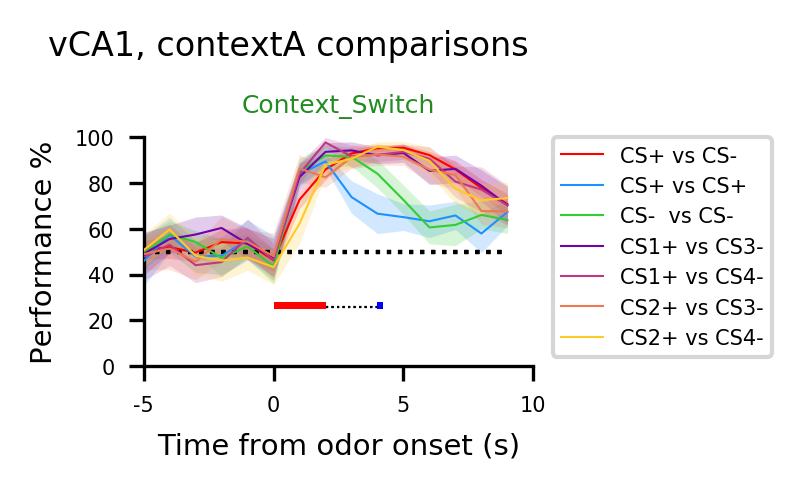

In [51]:
fig, ax = pl.subplots(figsize=(2, 1.5))

for comp,c,la in zip(comparisonsA,comp_colors,compA_labels):
    for r,sess in zip(range(3),sessions):
        ax.plot([(t-7) for t in range(17)], [(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(17)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(17)])
        s = np.array([np.std(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(17)])
        ax.fill_between([(t-7) for t in range(17)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax.set_ylim(0, 100)
    ax.set_xlim(-5, 9)
    ax.set_xticks(np.arange(-5,11, 5))
    ax.set_xticklabels(np.arange(-5,11, 5))
    ax.hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax.set_xlabel('Time from odor onset (s)')
    ax.set_ylabel('Performance %')
    pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.set_title('Context_Switch', color=dark_co[0],fontsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("vCA1, contextA comparisons", fontsize=8, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_CSPvsCSM_contextA.pdf'%NOTEBOOK_NAME)

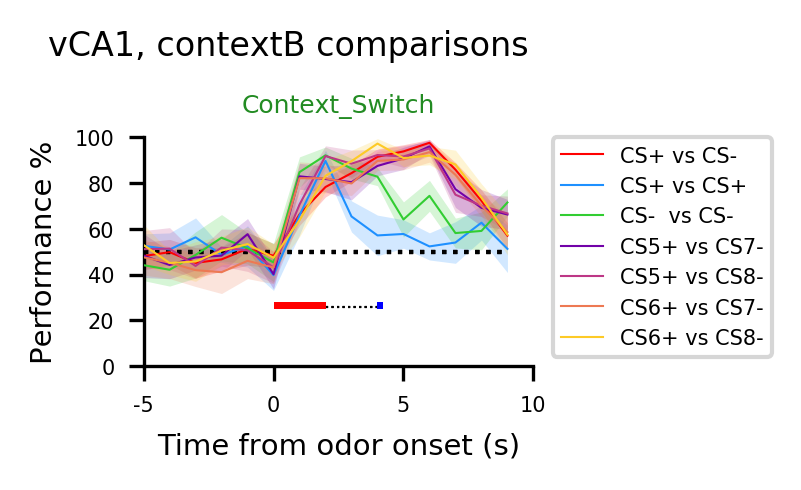

In [52]:
fig, ax = pl.subplots(figsize=(2, 1.5))

for comp,c,la in zip(comparisonsB,comp_colors,compB_labels):
    for r,sess in zip(range(3),sessions):
        ax.plot([(t-7) for t in range(17)], [(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(17)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(17)])
        s = np.array([np.std(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(17)])
        ax.fill_between([(t-7) for t in range(17)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax.set_ylim(0, 100)
    ax.set_xlim(-5, 9)
    ax.set_xticks(np.arange(-5,11, 5))
    ax.set_xticklabels(np.arange(-5,11, 5))
    ax.hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax.set_xlabel('Time from odor onset (s)')
    ax.set_ylabel('Performance %')
    pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.set_title('Context_Switch', color=dark_co[0],fontsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("vCA1, contextB comparisons", fontsize=8, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_CSPvsCSM_contextB.pdf'%NOTEBOOK_NAME)

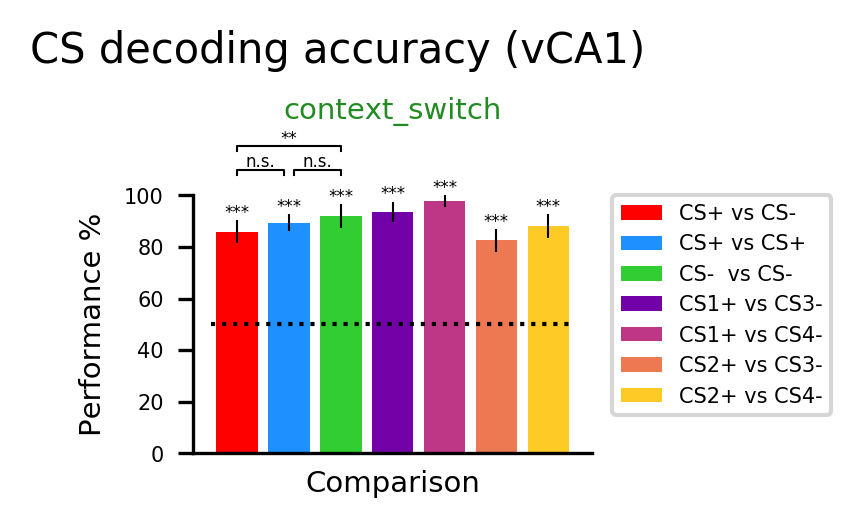

In [55]:
fig, ax = pl.subplots(figsize=(2, 1.7))
loops=15
for comp,c,la,i in zip(comparisonsA,comp_colors,compA_labels,range(len(comparisons))):
    ax.bar(i,np.mean(eval("scores_tb_9_%s['context_switch'][:loops]"%(comp)))*100,width=.8, color=c,label=la)
    exec("s_%s_%s = np.array(np.std(scores_tb_9_%s['context_switch'][:loops])*100)"%(comp,sess,comp))
    ax.errorbar(i,np.mean(eval("scores_tb_9_%s['context_switch'][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
ax.set_ylim(0, 100)
#ax.set_xlim(-5, 9)
ax.hlines(50, -0.5,6.5, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Comparison')
ax.set_ylabel('Performance %')
ax.tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
pvs.append(add_significance(ax, eval("scores_tb_9_%s['context_switch']"%(comparisonsA[0]))[:loops],
            eval("scores_tb_9_%s['context_switch']"%(comparisonsA[1]))[:loops],0,.9,110))
pvs.append(add_significance(ax, eval("scores_tb_9_%s['context_switch']"%(comparisonsA[1]))[:loops],
            eval("scores_tb_9_%s['context_switch']"%(comparisonsA[2]))[:loops],1.1,2,110))
pvs.append(add_significance(ax, eval("scores_tb_9_%s['context_switch']"%(comparisonsA[0]))[:loops],
            eval("scores_tb_9_%s['context_switch']"%(comparisonsA[2]))[:loops],0,2,119))
for comp,i in zip(comparisonsA, range(len(comparisonsA))):
    pvs.append(sig_vs_chance(ax,eval("scores_tb_9_%s['context_switch']"%(comp))[:loops],.5,i,
        np.mean(eval("scores_tb_9_%s['context_switch'][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax.set_title('context_switch', color=dark_co[0], y=1.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (vCA1)", fontsize=10, y=1)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_CSPvsCSM_contextA_bars.pdf'%NOTEBOOK_NAME)

In [53]:
context_comparisons = ['CS1vsCS5','CS2vsCS6','CS3vsCS7','CS4vsCS8']
context_labels = ['CS1+ vs CS5+','CS2+ vs CS6+','CS3-  vs  CS7-','CS4-  vs  CS8-']

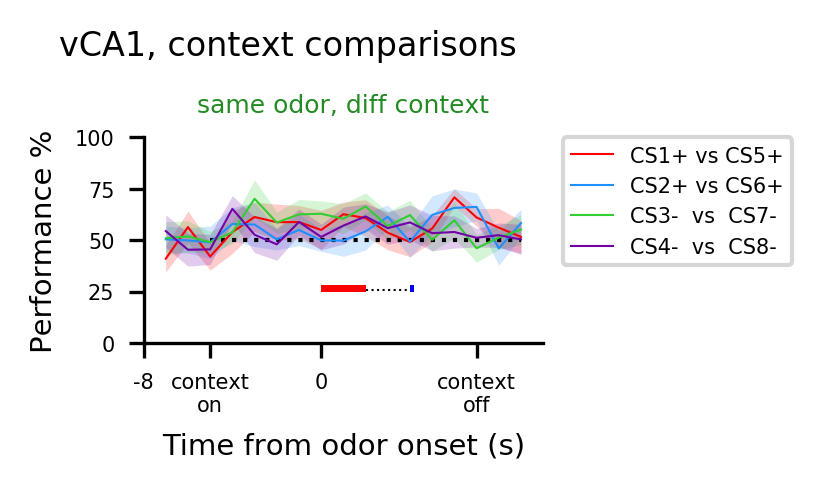

In [6]:
fig, ax = pl.subplots(figsize=(2, 1.5))

for comp,c,la in zip(context_comparisons,comp_colors,context_labels):
    for r,sess in zip(range(3),sessions):
        ax.plot([(t-7) for t in range(17)], [(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(17)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(17)])
        s = np.array([np.std(eval("scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(17)])
        ax.fill_between([(t-7) for t in range(17)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

ax.set_ylim(0, 100)
ax.set_xlim(-8, 10)
ax.set_xticks([-8,-5,0,7])
ax.set_xticklabels(['-8','context\non','0','context\noff'])
ax.hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.set_title('same odor, diff context', color=dark_co[0],fontsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("vCA1, context comparisons", fontsize=8, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_same_odor_across_contexts.pdf'%NOTEBOOK_NAME)

/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


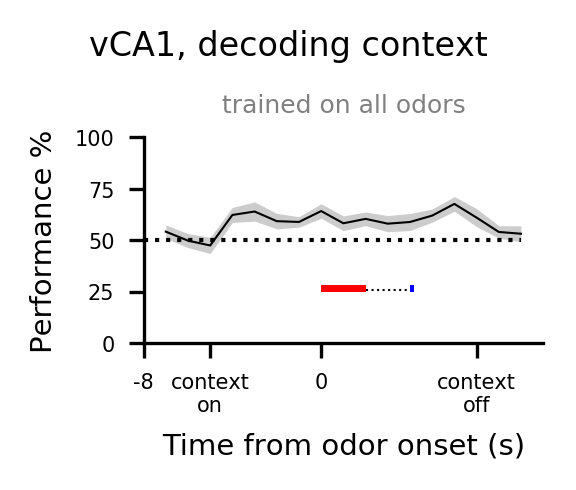

In [7]:
fig, ax = pl.subplots(figsize=(2, 1.5))

ax.plot([(t-7) for t in range(17)], [(np.mean(eval("scores_tb_%s_contextAvsB[sess]"%t))*100) for t in range(17)],
           color='k', ls='-',lw=.5, zorder=19 ,ms=1)
m = np.array([(np.mean(eval("scores_tb_%s_contextAvsB[sess]"%t))*100) for t in range(17)])
s = np.array([np.std(eval("scores_tb_%s_contextAvsB[sess]"%t))*100 for t in range(17)])
ax.fill_between([(t-7) for t in range(17)],m-s,m+s,alpha=0.2,color='k',linewidth=0)
ax.set_ylim(0, 100)
ax.set_xlim(-8, 10)
ax.set_xticks([-8,-5,0,7])
ax.set_xticklabels(['-8','context\non','0','context\noff'])
ax.hlines(50, -8,9, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax.set_title('trained on all odors', color='grey',fontsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("vCA1, decoding context", fontsize=8, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../figures/%s_context.pdf'%NOTEBOOK_NAME)

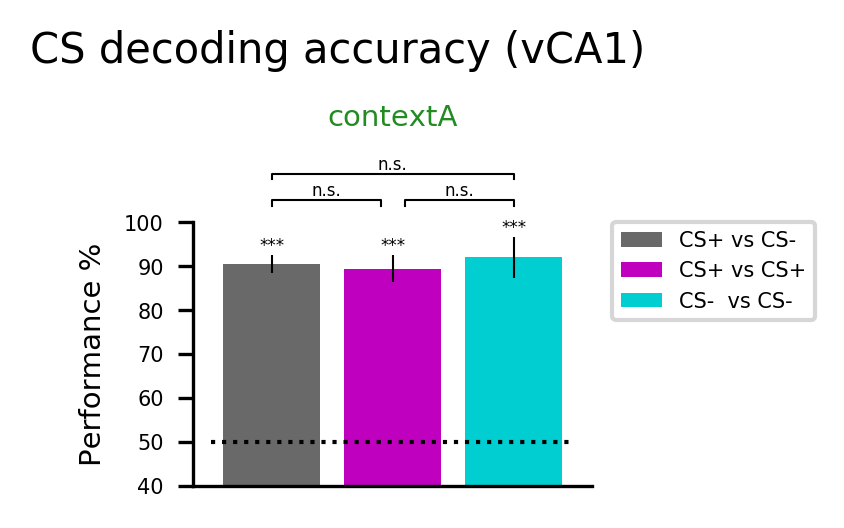

In [134]:
fig, ax = pl.subplots(figsize=(2, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisonsA[:3],['dimgrey','m','darkturquoise'],compA_labels[:3],range(len(comparisons[:3]))):
    ax.bar(i,np.mean(eval("scores_tb_9_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
    exec("s_%s_%s = np.array(np.std(scores_tb_9_%s[sess][:loops])*100)"%(comp,sess,comp))
    ax.errorbar(i,np.mean(eval("scores_tb_9_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
ax.set_ylim(40, 100)
#ax[x].set_xlim(-5, 9)
ax.hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
#ax[x].set_xlabel('Comparison')
ax.set_ylabel('Performance %')
ax.tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
pvs.append(add_significance(ax, eval("scores_tb_9_%s[sess]"%(alt_comparisonsA[0]))[:loops],
            eval("scores_tb_9_%s[sess]"%(alt_comparisonsA[1]))[:loops],0,.9,105))
pvs.append(add_significance(ax, eval("scores_tb_9_%s[sess]"%(alt_comparisonsA[1]))[:loops],
            eval("scores_tb_9_%s[sess]"%(alt_comparisonsA[2]))[:loops],1.1,2,105))
pvs.append(add_significance(ax, eval("scores_tb_9_%s[sess]"%(alt_comparisonsA[0]))[:loops],
            eval("scores_tb_9_%s[sess]"%(alt_comparisonsA[2]))[:loops],0,2,111))
for comp,i in zip(alt_comparisonsA[:3], range(len(alt_comparisonsA[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax,eval("scores_tb_9_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_9_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax.set_title('contextA', color=dark_co[0], y=1.27)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (vCA1)", fontsize=10, y=1)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_bars_CSA.pdf'%NOTEBOOK_NAME)

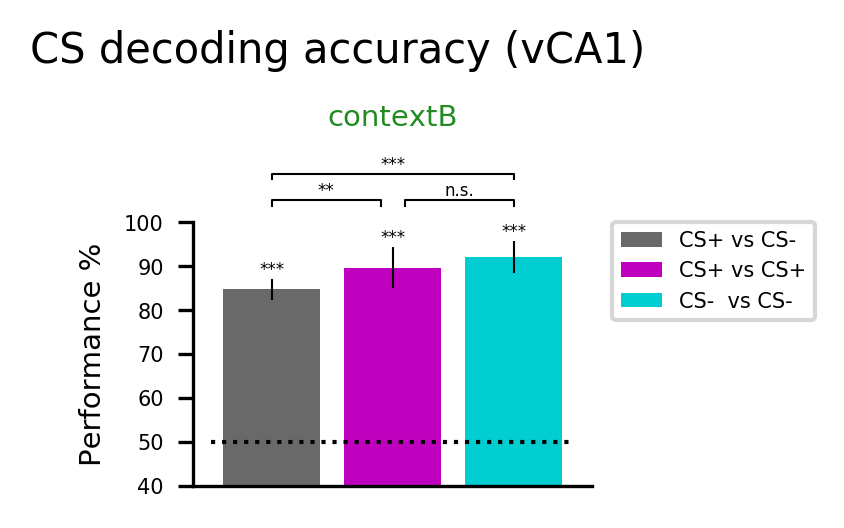

In [138]:
fig, ax = pl.subplots(figsize=(2, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisonsB[:3],['dimgrey','m','darkturquoise'],compB_labels[:3],range(len(comparisons[:3]))):
    ax.bar(i,np.mean(eval("scores_tb_9_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
    exec("s_%s_%s = np.array(np.std(scores_tb_9_%s[sess][:loops])*100)"%(comp,sess,comp))
    ax.errorbar(i,np.mean(eval("scores_tb_9_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
ax.set_ylim(40, 100)
#ax[x].set_xlim(-5, 9)
ax.hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
#ax[x].set_xlabel('Comparison')
ax.set_ylabel('Performance %')
ax.tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
pvs.append(add_significance(ax, eval("scores_tb_9_%s[sess]"%(alt_comparisonsB[0]))[:loops],
            eval("scores_tb_9_%s[sess]"%(alt_comparisonsB[1]))[:loops],0,.9,105))
pvs.append(add_significance(ax, eval("scores_tb_9_%s[sess]"%(alt_comparisonsB[1]))[:loops],
            eval("scores_tb_9_%s[sess]"%(alt_comparisonsB[2]))[:loops],1.1,2,105))
pvs.append(add_significance(ax, eval("scores_tb_9_%s[sess]"%(alt_comparisonsB[0]))[:loops],
            eval("scores_tb_9_%s[sess]"%(alt_comparisonsB[2]))[:loops],0,2,111))
for comp,i in zip(alt_comparisonsB[:3], range(len(alt_comparisonsB[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax,eval("scores_tb_9_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_9_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax.set_title('contextB', color=dark_co[0], y=1.27)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (vCA1)", fontsize=10, y=1)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_bars_CSB.pdf'%NOTEBOOK_NAME)

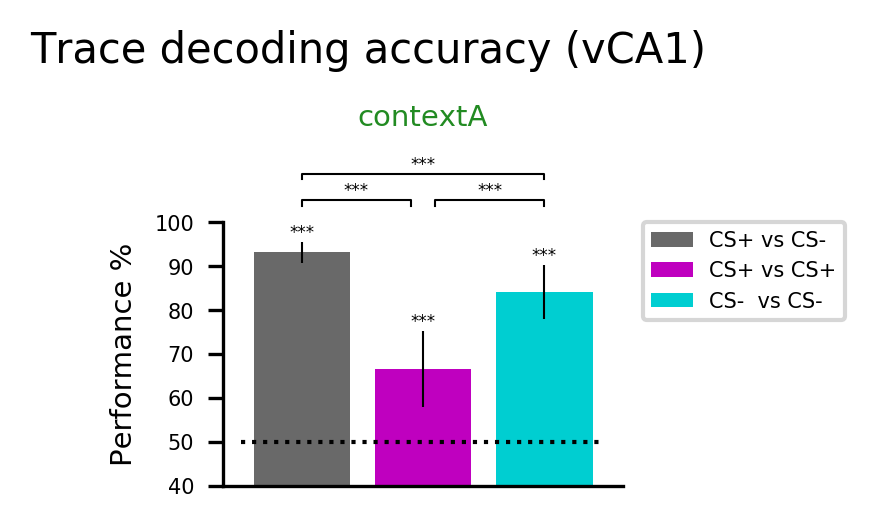

In [137]:
fig, ax = pl.subplots(figsize=(2, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisonsA[:3],['dimgrey','m','darkturquoise'],compA_labels[:3],range(len(comparisons[:3]))):
    ax.bar(i,np.mean(eval("scores_tb_11_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
    exec("s_%s_%s = np.array(np.std(scores_tb_11_%s[sess][:loops])*100)"%(comp,sess,comp))
    ax.errorbar(i,np.mean(eval("scores_tb_11_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
ax.set_ylim(40, 100)
#ax[x].set_xlim(-5, 9)
ax.hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
#ax[x].set_xlabel('Comparison')
ax.set_ylabel('Performance %')
ax.tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
pvs.append(add_significance(ax, eval("scores_tb_11_%s[sess]"%(alt_comparisonsA[0]))[:loops],
            eval("scores_tb_11_%s[sess]"%(alt_comparisonsA[1]))[:loops],0,.9,105))
pvs.append(add_significance(ax, eval("scores_tb_11_%s[sess]"%(alt_comparisonsA[1]))[:loops],
            eval("scores_tb_11_%s[sess]"%(alt_comparisonsA[2]))[:loops],1.1,2,105))
pvs.append(add_significance(ax, eval("scores_tb_11_%s[sess]"%(alt_comparisonsA[0]))[:loops],
            eval("scores_tb_11_%s[sess]"%(alt_comparisonsA[2]))[:loops],0,2,111))
for comp,i in zip(alt_comparisonsA[:3], range(len(alt_comparisonsA[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax,eval("scores_tb_11_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_11_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax.set_title('contextA', color=dark_co[0], y=1.27)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Trace decoding accuracy (vCA1)", fontsize=10, y=1)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_bars_TrA.pdf'%NOTEBOOK_NAME)

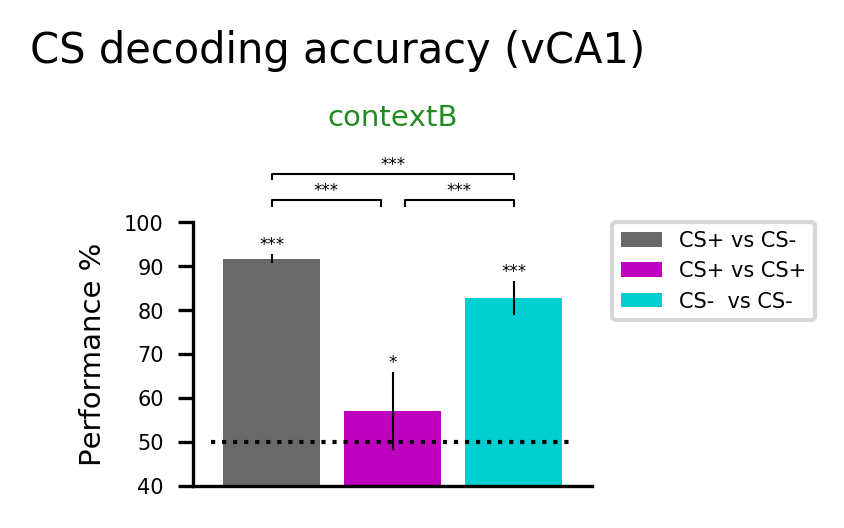

In [139]:
fig, ax = pl.subplots(figsize=(2, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisonsB[:3],['dimgrey','m','darkturquoise'],compB_labels[:3],range(len(comparisons[:3]))):
    ax.bar(i,np.mean(eval("scores_tb_11_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
    exec("s_%s_%s = np.array(np.std(scores_tb_11_%s[sess][:loops])*100)"%(comp,sess,comp))
    ax.errorbar(i,np.mean(eval("scores_tb_11_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
ax.set_ylim(40, 100)
#ax[x].set_xlim(-5, 9)
ax.hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
#ax[x].set_xlabel('Comparison')
ax.set_ylabel('Performance %')
ax.tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
pvs.append(add_significance(ax, eval("scores_tb_11_%s[sess]"%(alt_comparisonsB[0]))[:loops],
            eval("scores_tb_11_%s[sess]"%(alt_comparisonsB[1]))[:loops],0,.9,105))
pvs.append(add_significance(ax, eval("scores_tb_11_%s[sess]"%(alt_comparisonsB[1]))[:loops],
            eval("scores_tb_11_%s[sess]"%(alt_comparisonsB[2]))[:loops],1.1,2,105))
pvs.append(add_significance(ax, eval("scores_tb_11_%s[sess]"%(alt_comparisonsB[0]))[:loops],
            eval("scores_tb_11_%s[sess]"%(alt_comparisonsB[2]))[:loops],0,2,111))
for comp,i in zip(alt_comparisonsB[:3], range(len(alt_comparisonsB[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax,eval("scores_tb_11_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_11_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax.set_title('contextB', color=dark_co[0], y=1.27)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (vCA1)", fontsize=10, y=1)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_bars_CSB.pdf'%NOTEBOOK_NAME)

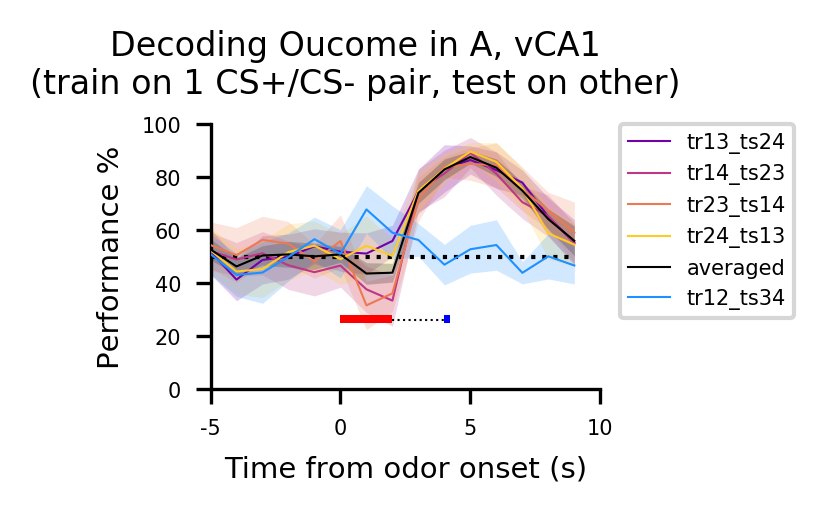

In [120]:
import copy
fig, ax = pl.subplots(figsize=(2, 1.5))
tt_colors_cont = copy.deepcopy(tt_colors_k)
tt_colors_cont.append('dodgerblue')
for comp,c,la in zip(['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','_averaged','tr12_ts34'],tt_colors_cont,['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged','tr12_ts34']):
        ax.plot([(t-7) for t in range(17)], [(np.mean(eval("scores_tb_%s_outcome_contextA%s[sess]"%(t,comp)))*100) for t in range(17)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_outcome_contextA%s[sess]"%(t,comp)))*100) for t in range(17)])
        s = np.array([np.std(eval("scores_tb_%s_outcome_contextA%s[sess]"%(t,comp)))*100 for t in range(17)])
        ax.fill_between([(t-7) for t in range(17)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
ax.set_ylim(0, 100)
ax.set_xlim(-5, 9)
ax.set_xticks(np.arange(-5,11, 5))
ax.set_xticklabels(np.arange(-5,11, 5))
ax.hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
#ax.set_title('Context_Switch', color=dark_co[0],fontsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding Oucome in A, vCA1\n(train on 1 CS+/CS- pair, test on other)", fontsize=8, y=1.10)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_outcomeA_horizontal.jpg'%NOTEBOOK_NAME)

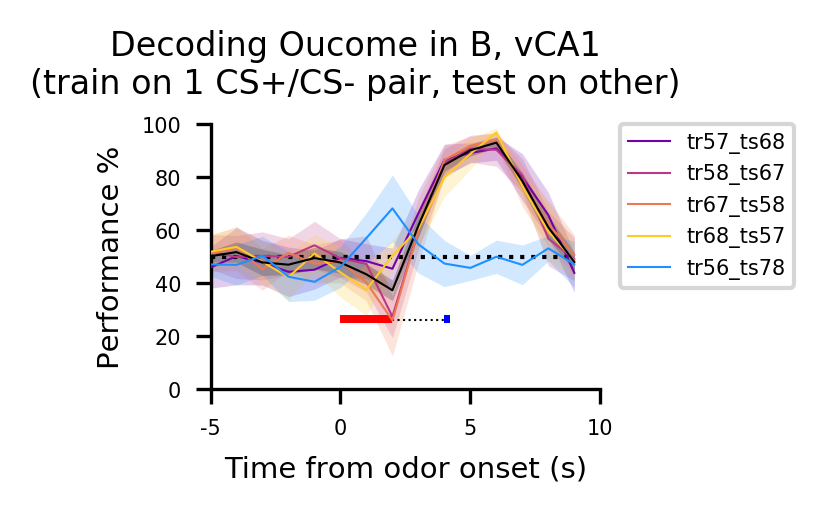

In [121]:
import copy
fig, ax = pl.subplots(figsize=(2, 1.5))
tt_colors_cont = copy.deepcopy(tt_colors_k)
tt_colors_cont.append('dodgerblue')
for comp,c,la in zip(['tr57_ts68','tr58_ts67','tr67_ts58','tr68_ts57','_averaged','tr56_ts78'],tt_colors_cont,['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged','tr12_ts34']):
        ax.plot([(t-7) for t in range(17)], [(np.mean(eval("scores_tb_%s_outcome_contextB%s[sess]"%(t,comp)))*100) for t in range(17)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=comp)
        m = np.array([(np.mean(eval("scores_tb_%s_outcome_contextB%s[sess]"%(t,comp)))*100) for t in range(17)])
        s = np.array([np.std(eval("scores_tb_%s_outcome_contextB%s[sess]"%(t,comp)))*100 for t in range(17)])
        ax.fill_between([(t-7) for t in range(17)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
ax.set_ylim(0, 100)
ax.set_xlim(-5, 9)
ax.set_xticks(np.arange(-5,11, 5))
ax.set_xticklabels(np.arange(-5,11, 5))
ax.hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=3)
pt.plot_period_bar(ax, 25, start_end=(4, 4.2), color='b', delta_y=3)
ax.hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
#ax.set_title('Context_Switch', color=dark_co[0],fontsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding Oucome in B, vCA1\n(train on 1 CS+/CS- pair, test on other)", fontsize=8, y=1.10)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_outcomeB_horizontal.jpg'%NOTEBOOK_NAME)

# Now for equalizing cell #s across all sess by using min

In [32]:
#get number of vHPC cells used for decoding
cell_total = ['total_cells_context_switch_vHPC']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_n_cells/')
    exec('%s = what'%(tot))
    print '%s ='%(tot),
    print what

 total_cells_context_switch_vHPC = 526


In [33]:
#get number of vHPC cells used for decoding
cell_total = ['total_cells_context_switch_dHPC']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_n_cells/')
    exec('%s = what'%(tot))
    print '%s ='%(tot),
    print what

total_cells_context_switch_dHPC = 488


In [34]:
gmin = np.min((total_cells_context_switch_vHPC,total_cells_context_switch_dHPC))
print gmin

vmin = np.min((total_cells_context_switch_vHPC))
print vmin

488
526


# And now for decoding across time bins! (using distinct trials for train/test)

In [56]:
def combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns_train.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns_train.copy()
    labels_t = labels.copy()
    for ani in patterns_train.keys():
        patterns_t[ani] = patterns_train[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns_test.copy()
        labels_T = labels.copy()
        for ani in patterns_test.keys():
            patterns_T[ani] = patterns_test[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_across_tbs(patterns_train, patterns_test, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

In [57]:
%%time
## decode for context
n_loops=15
relabel = {1:0,2:0,3:0,4:0,5:1,6:1,7:1,8:1}
for t in range(17): # number of time bins
    for c in range(17):
        exec('scores_tb_%s_VS_%s_contextAvsB = {}'%(t,c))
        for sess in sessions:
            print sess,t,c," ",
            eval('scores_tb_%s_VS_%s_contextAvsB'%(t,c))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                  eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,9),
                  n_cells=None, relabel=relabel) for i in range(n_loops)]]

context_switch 0 0   context_switch 0 1   context_switch 0 2   context_switch 0 3   context_switch 0 4   context_switch 0 5   context_switch 0 6   context_switch 0 7   context_switch 0 8   context_switch 0 9   context_switch 0 10   context_switch 0 11   context_switch 0 12   context_switch 0 13   context_switch 0 14   context_switch 0 15   context_switch 0 16   context_switch 1 0   context_switch 1 1   context_switch 1 2   context_switch 1 3   context_switch 1 4   context_switch 1 5   context_switch 1 6   context_switch 1 7   context_switch 1 8   context_switch 1 9   context_switch 1 10   context_switch 1 11   context_switch 1 12   context_switch 1 13   context_switch 1 14   context_switch 1 15   context_switch 1 16   context_switch 2 0   context_switch 2 1   context_switch 2 2   context_switch 2 3   context_switch 2 4   context_switch 2 5   context_switch 2 6   context_switch 2 7   context_switch 2 8   context_switch 2 9   context_switch 2 10   context_switch 2 11   context_switch 2 1

### running the cell below will take over an hour!

#%%time
#n_loops=15
#for t in range(17):
#    for c in range(17):
#        for comp,relab in zip(comparisons,relabels):
#            exec('scores_tb_%s_VS_%s_%s = {}'%(t,c,comp))
#            for sess in sessions:
#                print sess,t,c,comp,
#                print " ",
#                eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
#                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,9),
#                      n_cells=None, relabel=relab) for i in range(n_loops)]]

#%%time
##now train on one set of CS+/CS-, decode on the other
#tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
#tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
#tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
#n_loops=30
#for t in range(17):
#    for c in range(17):
#        for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
#            exec('scores_tb_%s_VS_%s_outcome_%s = {}'%(t,c,it))
#            for sess in sessions:
#                print sess,t,c,it,
#                print " ",
#                eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,it))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
#                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,9),
#                      n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

#for outcome endoding, average each idividual comparison
for t in range(17):
    for c in range(17):
        exec("scores_tb_%s_VS_%s_outcome_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_outcome_averaged[sess] = np.mean((scores_tb_%s_VS_%s_outcome_tr13_ts24[sess],\
                 scores_tb_%s_VS_%s_outcome_tr14_ts23[sess],scores_tb_%s_VS_%s_outcome_tr23_ts14[sess],\
                 scores_tb_%s_VS_%s_outcome_tr24_ts13[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

#for outcome endoding, average each idividual comparison
for t in range(17):
    for c in range(17):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4[sess],scores_tb_%s_VS_%s_CS2vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

for t in range(17):
    for comp in comparisons_av:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range(17):
        for comp in comparisons_av:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range(17):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess].mean()))

#for t in range(17):
#    exec('distinct%s_%s_ttest = {}'%(t,comp))
#for sess in sessions:
#    for t in range(17):
#        exec("distinct%s_%s_ttest['%s'] = []"%(t,sess))
#        for c in range(17):
#            eval('distinct%s_%s_ttest'%t)[sess].insert(c,
#                (sstats.ttest_1samp(eval('scores_gmin_tb_distinct_%s_VS_%s[sess].mean(1)[:15]'%(t,c)),.5)))
#        for x,i in zip(eval('distinct%s_%s_ttest'%t)[sess],range(len(eval('distinct%s_%s_ttest'%t)[sess]))):
#            exec("distinct%s_%s_ttest[sess][i] = x[-1]"%(t)) #only take p-values

for t in range(17):
    for comp in comparisons_av:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range(17):
        for comp in comparisons_av:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range(17):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in comparisons_av:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

for comp in comparisons_av:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

In [58]:
for t in range(17):
    for comp in ['contextAvsB']:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range(17):
        for comp in ['contextAvsB']:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range(17):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess].mean()))

In [59]:
for t in range(17):
    for comp in ['contextAvsB']:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range(17):
        for comp in ['contextAvsB']:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range(17):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

In [68]:
for comp in ['contextAvsB']:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess], distinct14_%s[sess], distinct15_%s[sess], distinct16_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

In [69]:
for comp in ['contextAvsB']:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess], distinct14_%s_wilcox[sess], distinct15_%s_wilcox[sess], distinct16_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

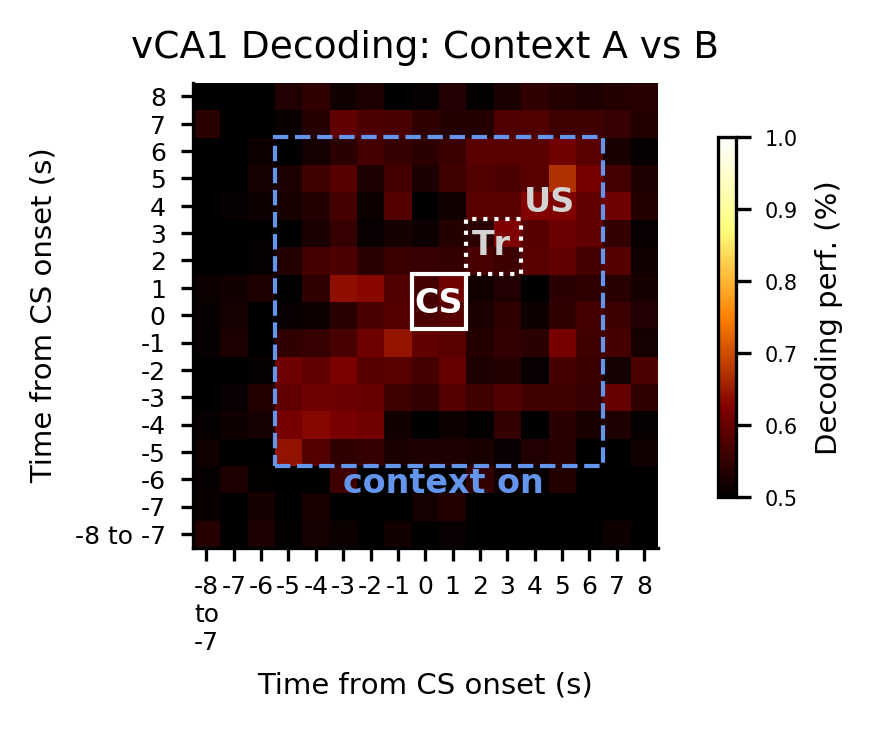

In [96]:
fig, ax = pl.subplots(figsize=(2, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
im = ax.imshow(distinct_contextAvsB['context_switch'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
ax.set_xticks(range(17))
ax.set_yticks(range(17))
#ax.set_ylim(2.5, 13.5)
#ax.set_xlim(2.5,13.5)
ax.set_xticklabels(['-8\nto\n-7','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5', '6','7','8'],fontsize=6)
ax.set_yticklabels(['-8 to -7','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5', '6','7','8'],fontsize=6)
ax.set_ylabel('Time from CS onset (s)', fontsize=7)
ax.set_xlabel('Time from CS onset (s)', fontsize=7)
ax.set_title('vCA1 Decoding: Context A vs B',fontsize=9,color='k')
ax.tick_params(length=3)

import matplotlib.patches as patches
# Create a Rectangle patch
CS = patches.Rectangle((7.5,7.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
Tr = patches.Rectangle((9.5,9.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
Context = patches.Rectangle((2.5,2.5),12,12,linewidth=1,edgecolor='cornflowerblue',facecolor='none',linestyle='--')
# Add the patch to the Axes
ax.add_patch(CS)
ax.add_patch(Tr)
ax.add_patch(Context)
#ax.hlines(25+1, 2, 4, color='b', lw=0.5, linestyles='dotted')

ax.text(5,1.5,"context on",fontsize=8, weight='bold', color='cornflowerblue')
ax.text(7.6,8.1,"CS",fontsize=8, weight='bold', color='w')
ax.text(9.7,10.2,"Tr",fontsize=8, weight='bold', color='lightgray')
ax.text(11.6,11.8,"US",fontsize=8, weight='bold', color='lightgray')

#pl.suptitle('vCA1 Decoding Performance: Context A vs B',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.03, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
#fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_across_bins_distinct_CSPvsCSM.jpg'%NOTEBOOK_NAME)

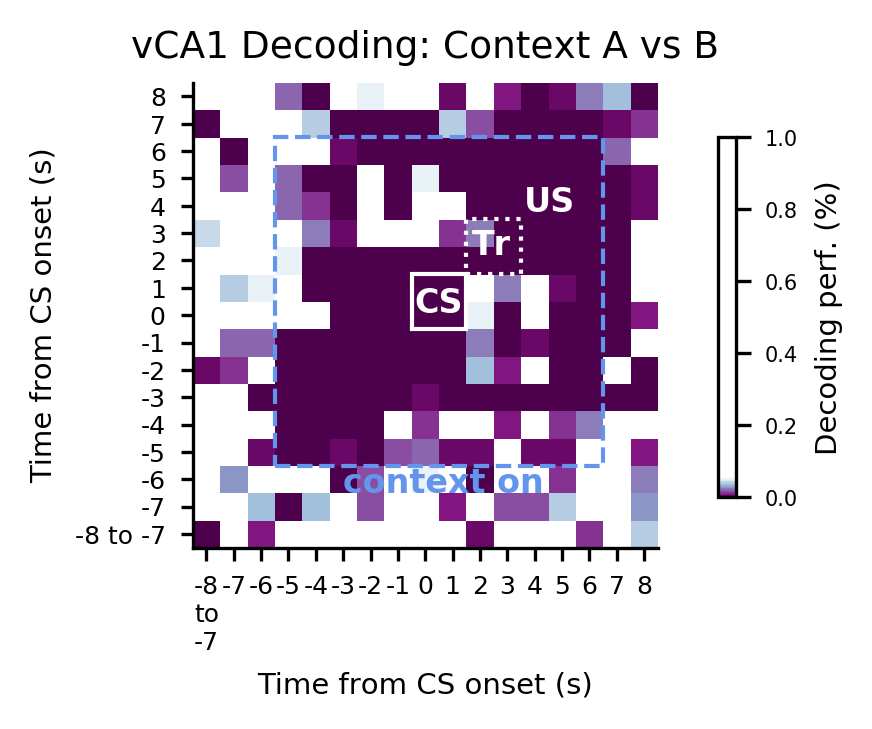

In [106]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(figsize=(2, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
im = ax.imshow(distinct_contextAvsB_wilcox['context_switch'],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
ax.set_xticks(range(17))
ax.set_yticks(range(17))
#ax.set_ylim(2.5, 13.5)
#ax.set_xlim(2.5,13.5)
ax.set_xticklabels(['-8\nto\n-7','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5', '6','7','8'],fontsize=6)
ax.set_yticklabels(['-8 to -7','-7','-6','-5','-4','-3','-2','-1','0','1','2','3','4','5', '6','7','8'],fontsize=6)
ax.set_ylabel('Time from CS onset (s)', fontsize=7)
ax.set_xlabel('Time from CS onset (s)', fontsize=7)
ax.set_title('vCA1 Decoding: Context A vs B',fontsize=9,color='k')
ax.tick_params(length=3)

import matplotlib.patches as patches
# Create a Rectangle patch
CS = patches.Rectangle((7.5,7.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
Tr = patches.Rectangle((9.5,9.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
Context = patches.Rectangle((2.5,2.5),12,12,linewidth=1,edgecolor='cornflowerblue',facecolor='none',linestyle='--')
# Add the patch to the Axes
ax.add_patch(CS)
ax.add_patch(Tr)
ax.add_patch(Context)
#ax.hlines(25+1, 2, 4, color='b', lw=0.5, linestyles='dotted')

ax.text(5,1.5,"context on",fontsize=8, weight='bold', color='cornflowerblue')
ax.text(7.6,8.1,"CS",fontsize=8, weight='bold', color='w')
ax.text(9.7,10.2,"Tr",fontsize=8, weight='bold', color='w')
ax.text(11.6,11.8,"US",fontsize=8, weight='bold', color='w')

#pl.suptitle('vCA1 Decoding Performance: Context A vs B',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.03, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
#fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_across_bins_distinct_CSPvsCSM.jpg'%NOTEBOOK_NAME)

In [ ]:
fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(17))
    ax[x].set_yticks(range(17))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('vCA1 Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_across_bins_LATE.jpg'%NOTEBOOK_NAME)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(17))
    ax[x].set_yticks(range(17))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('vCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

### now for decoding outcome plots

In [107]:
tt_pairs_avg = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
tt_labels = ['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average']

In [108]:
for t in range(17):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range(17):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range(17):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,comp))[sess].mean()))

NameError: name 'scores_tb_0_VS_0_outcome_tr13_ts24' is not defined

In [ ]:
for t in range(17):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range(17):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range(17):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_outcome_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

In [ ]:
for comp in tt_pairs_avg:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

In [ ]:
for comp in tt_pairs_avg:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

In [ ]:
fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(17))
    ax[x].set_yticks(range(17))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('vCA1 Decoding Performance: Outcome',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

In [ ]:
fig, ax = pl.subplots(5, 3, figsize=(6, 15))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
        im = ax[i][x].imshow(eval("distinct_%s[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(17))
        ax[i][x].set_yticks(range(17))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,tt_labels[i],fontsize=11)

import matplotlib.patches as patches
for i in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('vCA1 Outcome Decoding Performance',y=1.,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

In [ ]:
fig, ax = pl.subplots(1, 5, figsize=(11, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (5):
    ax[x].set_xticks(range(17))
    ax[x].set_yticks(range(17))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1.5,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='w')
ax[0].text(7.1,7.4,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('vCA1 Outcome Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(17))
    ax[x].set_yticks(range(17))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('vCA1 Outcome Decoding p-values (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 5, figsize=(8, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (5):
    ax[x].set_xticks(range(17))
    ax[x].set_yticks(range(17))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('vCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

In [141]:
save_workspace(db)

Could not store variable 'patches'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'copy'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'cm'. Skipping...
